# Importando Bibliotecas

In [43]:
import pandas as pd
import numpy as np

from scipy.stats import normaltest

from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

import pickle

import warnings
warnings.filterwarnings('ignore')

# Funções

In [2]:
def normal_test(feature, array, alpha=0.05):
    p = normaltest(array).pvalue
    if p < alpha:
        print(f'Rejeita H0. A feature {feature} NÃO está normalmente distribuída')
    else:
        print(f'Aceita H0. A feature {feature} está normalmente distribuída. P-valor = {p} >= {alpha}')

In [3]:
def teste_hipotese(array1, array2, alpha=0.05):
    tstat, pvalue = ztest(array1, array2, value=0)
    if pvalue < 0.05:
        return 'Rejeita-se H0, há uma diferença entre as médias'
    else:
        return 'Aceita-se H0, NÃO há uma diferença entre as médias'

In [4]:
def obter_target(target):
    if target == 'male':
        return 1
    else:
        return 0

# Lendo os Dados

In [5]:
df = pd.read_csv('../dados/data.csv')
df

,mean,sd,median,mode,q25,q75,iqr,skew,kurt,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,label
0,1808.092287,1990.436004,782.362729,98.835275,365.723794,3184.692180,2818.968386,5.096127,36.714087,0.132613,0.014204,2.776143,0.220610,0.207588,0.813328,0.007252,0.211261,male
1,2200.046049,2274.187035,955.159290,117.462955,351.461525,4268.851065,3917.389540,7.525938,85.611556,0.151185,0.031811,2.755876,0.257105,0.227426,0.944803,0.008513,0.247871,male
2,1675.355751,2147.506127,556.424261,119.998089,225.474117,2382.637219,2157.163102,8.714798,115.775205,0.112272,0.014426,2.627035,0.228569,0.225899,0.689215,0.015155,0.216506,male
3,1974.211667,1986.024539,925.484438,144.355789,451.305037,3254.032959,2802.727923,4.360345,26.907695,0.182504,0.015273,2.742456,0.267155,0.213000,1.016115,0.008579,0.297207,male
4,1798.853498,1842.831468,949.250000,135.250000,376.750000,2776.000000,2399.250000,6.768834,69.747551,0.089617,0.016476,2.795043,0.201541,0.208583,0.721911,0.012701,0.155377,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9061,2176.504278,2219.570297,1114.115308,182.902584,239.363817,3847.713718,3608.349901,13.680722,253.117683,0.116889,0.056615,2.891328,0.210920,0.210231,0.724152,0.010892,0.180177,female
9062,2027.550253,2212.227248,867.364747,173.821990,483.420593,2841.535777,2358.115183,8.323516,127.835342,0.204503,0.028066,2.814642,0.292336,0.220678,0.858237,0.010405,0.301394,female
9063,2414.310759,2515.698997,948.470209,195.169082,350.402576,5023.188406,4672.785829,12.584704,216.607914,0.220560,0.031528,2.833599,0.313691,0.225406,0.817461,0.011350,0.316728,female
9064,1615.214400,1751.907921,903.012300,197.444230,397.121270,1999.641155,1602.519886,9.768030,153.560083,0.133332,0.034586,2.799910,0.230782,0.209851,0.788931,0.009578,0.205444,female


# EDA

**Dicionario de Dados**:
- ``meanfreq`` - mean frequency (in kHz)
- ``sd`` - standard deviation of frequency
- ``median`` - median frequency (in kHz)
- ``Q25`` - first quantile (in kHz)
- ``Q75`` - third quantile (in kHz)
- ``IQR`` - interquantile range (in kHz)
- ``skew`` - skewness (see note in specprop description)
- ``kurt`` - kurtosis (see note in specprop description)
- ``sp.ent`` - spectral entropy
- ``sfm`` - spectral flatness
- ``mode`` - mode frequency
- ``centroid`` - frequency centroid (see specprop)
- ``meanfun`` - average of fundamental frequency measured across acoustic signal
- ``minfun`` - minimum fundamental frequency measured across acoustic signal
- ``maxfun`` - maximum fundamental frequency measured across acoustic signal
- ``meandom`` - average of dominant frequency measured across acoustic signal
- ``mindom`` - minimum of dominant frequency measured across acoustic signal
- ``maxdom`` - maximum of dominant frequency measured across acoustic signal
- ``dfrange`` - range of dominant frequency measured across acoustic signal
- ``modindx`` - modulation index. Calculated as the accumulated absolute difference between

### Estatísticas Gerais

In [6]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mean,9066.0,NaN,NaN,NaN,1658.285386,386.646934,593.652497,1370.220668,1622.954663,1917.515982,3221.440578
sd,9066.0,NaN,NaN,NaN,1838.014882,330.38172,905.900599,1567.455731,1882.230577,2106.827309,2615.605796
median,9066.0,NaN,NaN,NaN,800.70267,333.306886,244.2041,618.25,734.0,899.249499,3475.872534
mode,9066.0,NaN,NaN,NaN,190.004796,107.708334,12.0,133.75,157.60385,193.086972,851.862347
q25,9066.0,NaN,NaN,NaN,336.358385,99.615658,100.662252,277.545843,345.920763,400.0,726.832223
q75,9066.0,NaN,NaN,NaN,2491.580103,930.417325,521.108412,1789.856688,2344.658429,3186.922588,5786.470662
iqr,9066.0,NaN,NaN,NaN,2155.221718,899.602454,398.295835,1455.215559,2005.333712,2815.444484,5397.11806
skew,9066.0,NaN,NaN,NaN,7.232785,2.660884,2.906542,5.255813,6.472275,8.626353,24.434624
kurt,9066.0,NaN,NaN,NaN,86.745325,66.295479,13.475064,40.976537,63.438354,110.989282,858.966572
zcr,9066.0,NaN,NaN,NaN,0.109187,0.040566,0.023968,0.074934,0.10592,0.138488,0.273144


### Valores Nulos

In [7]:
df.isna().sum()

mean                 0
sd                   0
median               0
mode                 0
q25                  0
q75                  0
iqr                  0
skew                 0
kurt                 0
zcr                  0
energy               0
energy_entropy       0
spectral_centroid    0
spectral_spread      0
spectral_entropy     0
spectral_flux        0
spectral_rolloff     0
label                0
dtype: int64

### Balanceamento

<AxesSubplot:xlabel='label', ylabel='count'>

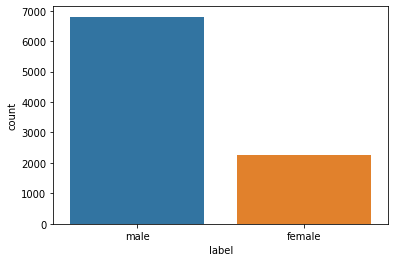

In [8]:
sns.countplot(df['label'])

### Teste de Normalidade

- Ho: A amostra **está** normalmente distribuída.(P>0.05)
- H1: A amostra **NÃO está** normalmente distribuída.

Rejeita H0. A feature mean NÃO está normalmente distribuída


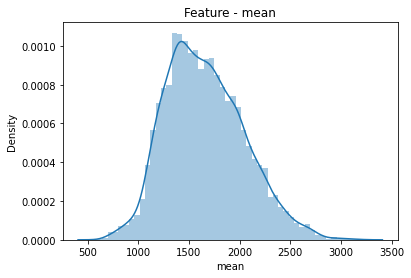

Rejeita H0. A feature sd NÃO está normalmente distribuída


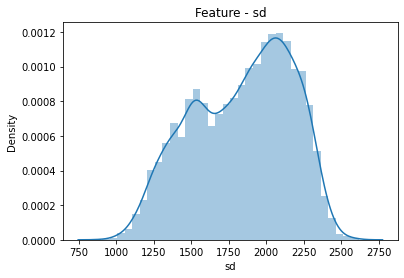

Rejeita H0. A feature median NÃO está normalmente distribuída


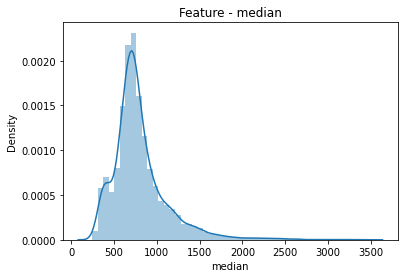

Rejeita H0. A feature mode NÃO está normalmente distribuída


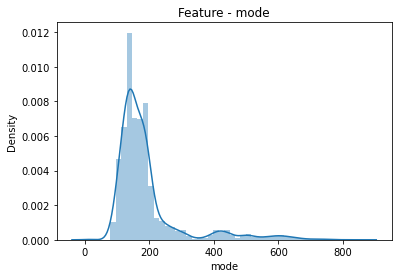

Rejeita H0. A feature q25 NÃO está normalmente distribuída


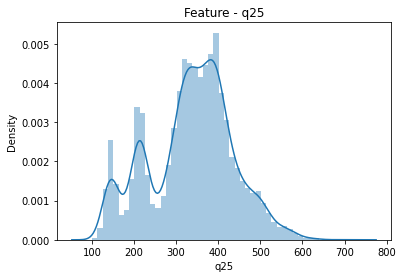

Rejeita H0. A feature q75 NÃO está normalmente distribuída


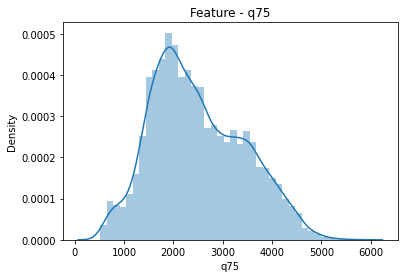

Rejeita H0. A feature iqr NÃO está normalmente distribuída


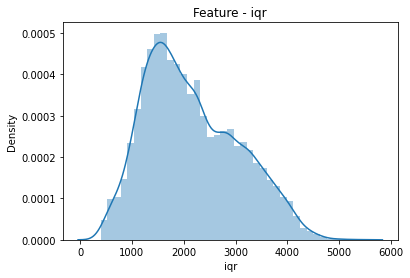

Rejeita H0. A feature skew NÃO está normalmente distribuída


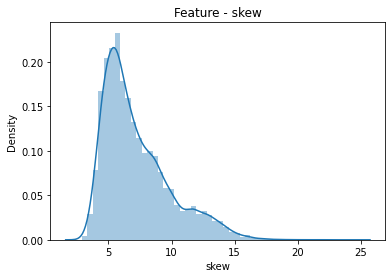

Rejeita H0. A feature kurt NÃO está normalmente distribuída


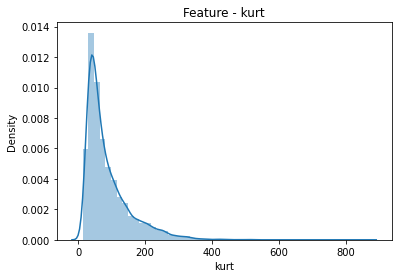

Rejeita H0. A feature zcr NÃO está normalmente distribuída


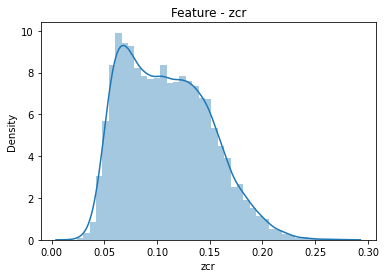

Rejeita H0. A feature energy NÃO está normalmente distribuída


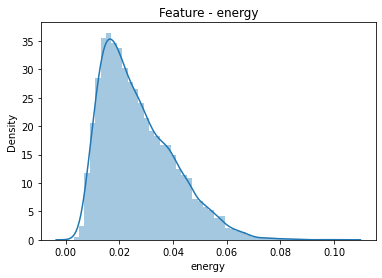

Rejeita H0. A feature energy_entropy NÃO está normalmente distribuída


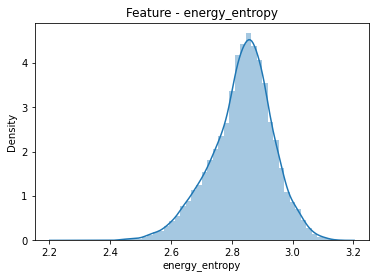

Rejeita H0. A feature spectral_centroid NÃO está normalmente distribuída


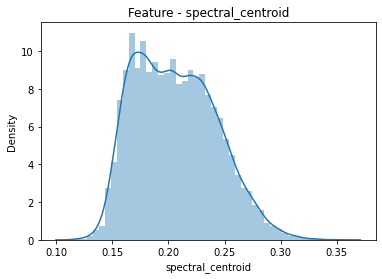

Rejeita H0. A feature spectral_spread NÃO está normalmente distribuída


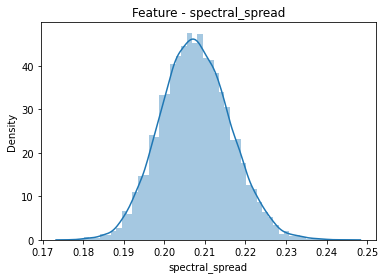

Rejeita H0. A feature spectral_entropy NÃO está normalmente distribuída


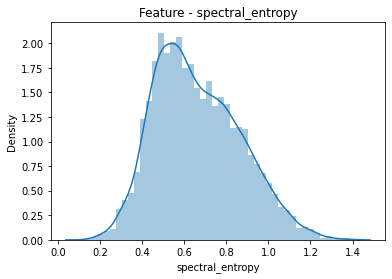

Rejeita H0. A feature spectral_flux NÃO está normalmente distribuída


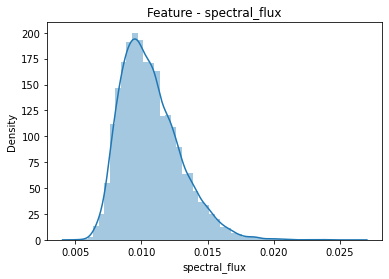

Rejeita H0. A feature spectral_rolloff NÃO está normalmente distribuída


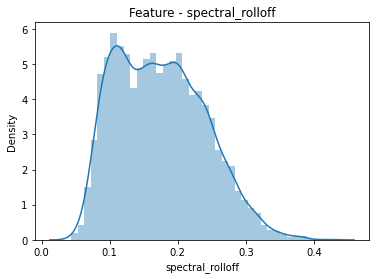

In [9]:
for column in df.drop('label', axis=1).columns:
    normal_test(column, df[column].values)
    plt.title(f'Feature - {column}')
    sns.distplot(df[column])
    plt.show()

### Correlações

<AxesSubplot:title={'center':'Correlation Heatmap'}>

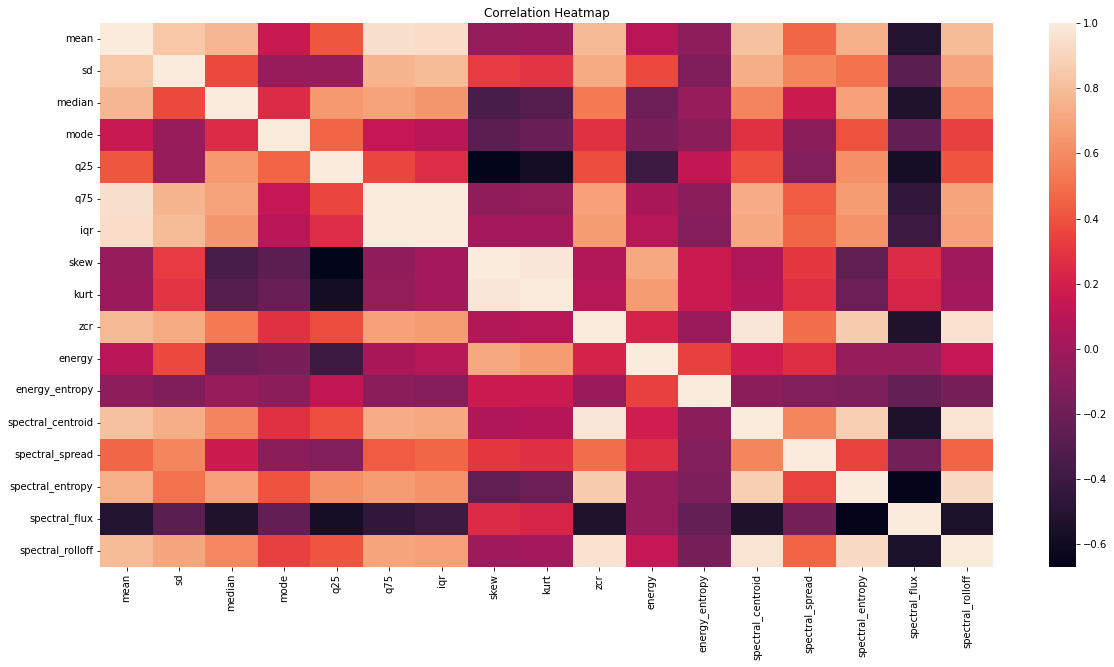

In [10]:
plt.figure(figsize=(20,10))
plt.title('Correlation Heatmap')
sns.heatmap(df.drop('label', axis=1).corr())

### Histogramas por Target

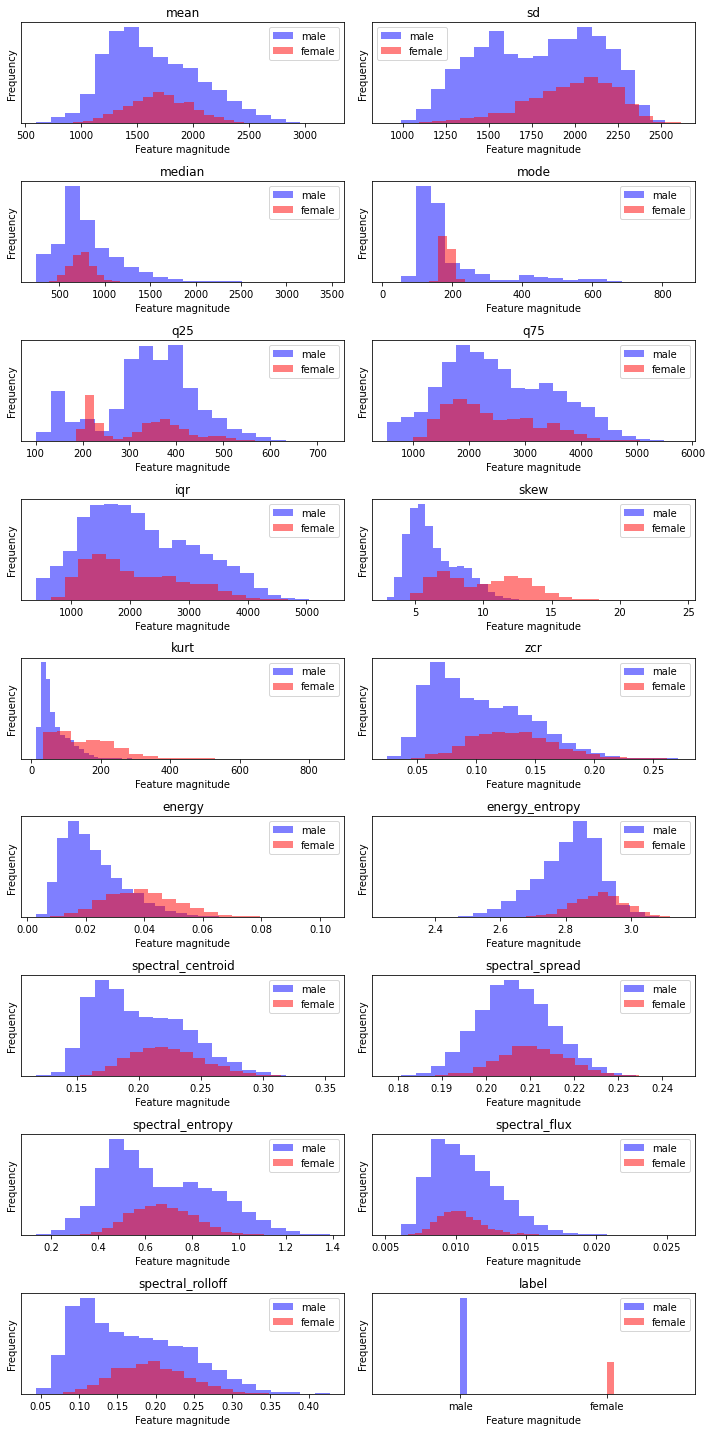

In [16]:
male = df.loc[df['label']=='male']
female = df.loc[df['label']=='female']
fig, axes = plt.subplots(9, 2, figsize=(10,20))
ax = axes.ravel()
for i in range(18):
    ax[i].hist(male.iloc[:,i], bins=20, color='blue', alpha=.5)
    ax[i].hist(female.iloc[:, i], bins=20, color='red', alpha=.5)
    ax[i].set_title(list(male)[i])
    ax[i].set_yticks(())
    
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["male", "female"], loc="best")
fig.tight_layout()

### Teste de Proporções

- Ho: **NÃO há** diferença entre as médias.(P>0.05)
- H1: **Há** diferença entre as médias.

Feature mean -- Rejeita-se H0, há uma diferença entre as médias


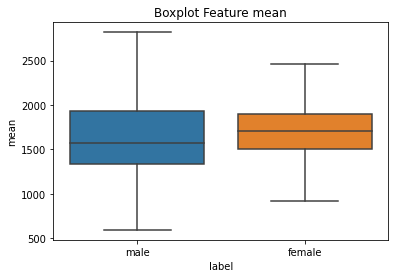

Feature sd -- Rejeita-se H0, há uma diferença entre as médias


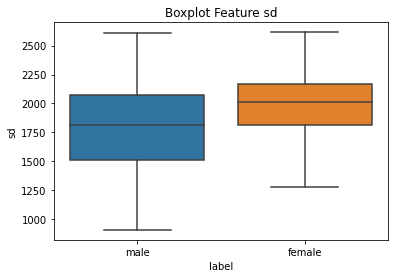

Feature median -- Rejeita-se H0, há uma diferença entre as médias


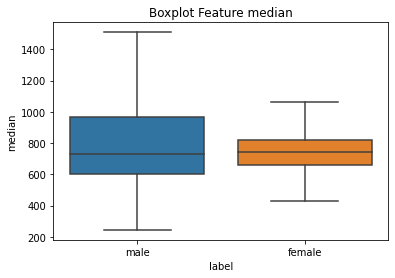

Feature mode -- Rejeita-se H0, há uma diferença entre as médias


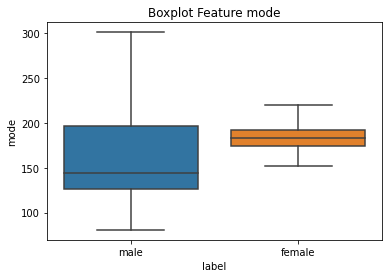

Feature q25 -- Rejeita-se H0, há uma diferença entre as médias


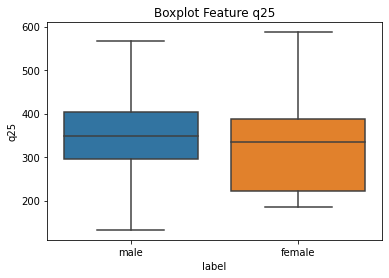

Feature q75 -- Rejeita-se H0, há uma diferença entre as médias


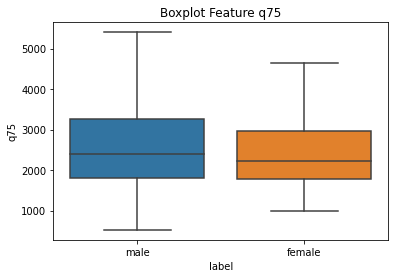

Feature iqr -- Rejeita-se H0, há uma diferença entre as médias


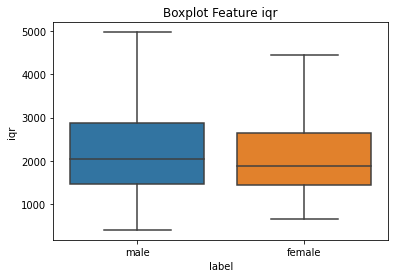

Feature skew -- Rejeita-se H0, há uma diferença entre as médias


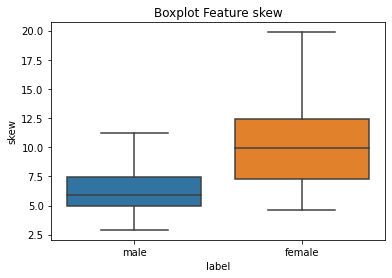

Feature kurt -- Rejeita-se H0, há uma diferença entre as médias


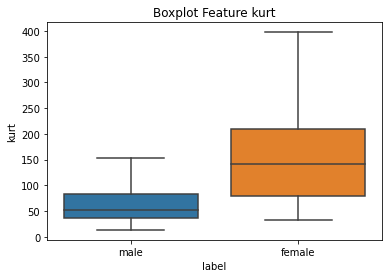

Feature zcr -- Rejeita-se H0, há uma diferença entre as médias


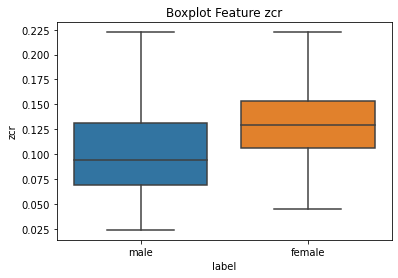

Feature energy -- Rejeita-se H0, há uma diferença entre as médias


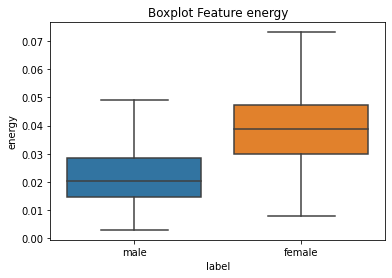

Feature energy_entropy -- Rejeita-se H0, há uma diferença entre as médias


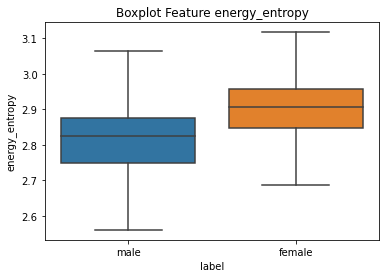

Feature spectral_centroid -- Rejeita-se H0, há uma diferença entre as médias


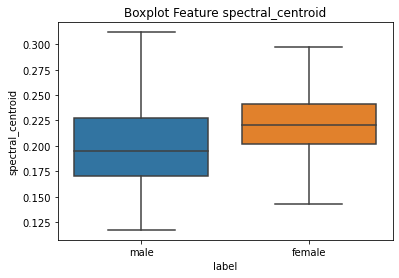

Feature spectral_spread -- Rejeita-se H0, há uma diferença entre as médias


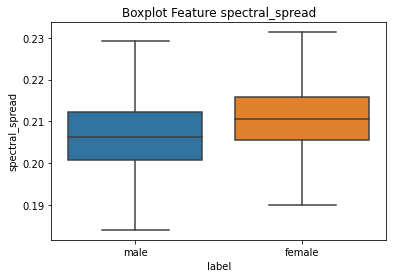

Feature spectral_entropy -- Rejeita-se H0, há uma diferença entre as médias


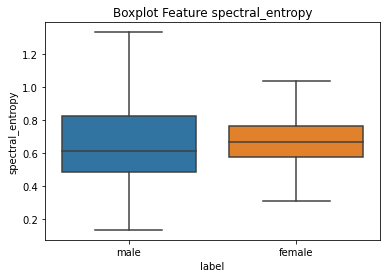

Feature spectral_flux -- Rejeita-se H0, há uma diferença entre as médias


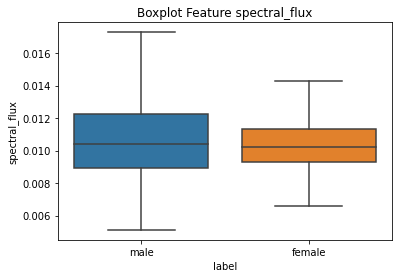

Feature spectral_rolloff -- Rejeita-se H0, há uma diferença entre as médias


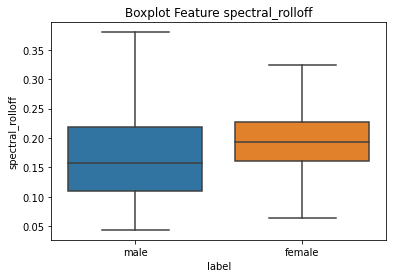

In [17]:
features_influenciadoras = []

for column in df.drop('label', axis=1).columns:
    df_m = df.loc[df['label'] == 'male']
    df_f = df.loc[df['label'] == 'female']
    array_m = df_m[column].tolist()
    array_f = df_f[column].tolist()
    hipotese = teste_hipotese(array_m, array_f)
    
    if hipotese == 'Rejeita-se H0, há uma diferença entre as médias':
        features_influenciadoras.append(column)
        print(f'Feature {column} -- {hipotese}')
        plt.title(f'Boxplot Feature {column}')
        sns.boxplot(data = df, y = column, x = 'label', showfliers=False)
        plt.show()

# Modelagem

### Divisão entre Treino e Teste

In [18]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [19]:
X = df.drop('label', axis=1)
y = df['label'].apply(obter_target)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

### Modelos

In [28]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [29]:
modelos = [LogisticRegression(class_weight='balanced'), DecisionTreeClassifier(class_weight='balanced'), SVC(class_weight='balanced'), AdaBoostClassifier(), GradientBoostingClassifier(), RandomForestClassifier(class_weight='balanced'), LGBMClassifier(class_weight='balanced'), XGBClassifier(sample_weight=sample_weights)]

In [30]:
metodos = []

for modelo in modelos:
    pipe = Pipeline(steps=[
        ('preprocessor', MinMaxScaler()),
        ('model', modelo)
    ])
    cv = cross_val_score(pipe, X_train, y_train, cv=skf)
    metodos.append({
        'metodo': modelo,
        'accuracy_mean': round(cv.mean(),4),
        'accuracy_std': round(cv.std(),4)
    })
    
metodos = pd.DataFrame(metodos)
metodos

[12:47:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:47:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:47:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  

,metodo,accuracy_mean,accuracy_std
0,LogisticRegression(class_weight='balanced'),0.9335,0.0072
1,DecisionTreeClassifier(class_weight='balanced'),0.9701,0.0070
2,SVC(class_weight='balanced'),0.9803,0.0051
3,AdaBoostClassifier(),0.9882,0.0047
4,GradientBoostingClassifier(),0.9894,0.0057
5,RandomForestClassifier(class_weight='balanced'),0.9858,0.0044
6,LGBMClassifier(class_weight='balanced'),0.9918,0.0037
7,"XGBClassifier(base_score=None, booster=None, c...",0.9915,0.0047


In [31]:
metodos.sort_values(by='accuracy_mean', ascending=False)

,metodo,accuracy_mean,accuracy_std
6,LGBMClassifier(class_weight='balanced'),0.9918,0.0037
7,"XGBClassifier(base_score=None, booster=None, c...",0.9915,0.0047
4,GradientBoostingClassifier(),0.9894,0.0057
3,AdaBoostClassifier(),0.9882,0.0047
5,RandomForestClassifier(class_weight='balanced'),0.9858,0.0044
2,SVC(class_weight='balanced'),0.9803,0.0051
1,DecisionTreeClassifier(class_weight='balanced'),0.9701,0.0070
0,LogisticRegression(class_weight='balanced'),0.9335,0.0072


# LightGBM

In [35]:
lgbm = Pipeline(steps=[
    ('preprocessor', MinMaxScaler()),
    ('model', LGBMClassifier(class_weight='balanced'))
    ])
lgbm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', MinMaxScaler()),
                ('model', LGBMClassifier(class_weight='balanced'))])

In [36]:
y_test_pred = lgbm.predict(X_test)

accuracy_test = round(metrics.accuracy_score(y_test, y_test_pred)*100,2)

precision_test = round(metrics.precision_score(y_test, y_test_pred)*100,2)

recall_test = round(metrics.recall_score(y_test, y_test_pred)*100,2)

f1_score_test = round(metrics.f1_score(y_test, y_test_pred)*100,2)

print(f'''
      As métricas do teste foram:
      Acurária = {accuracy_test}%
      Precisão = {precision_test}%
      Recall = {recall_test}%
      F1 Score = {f1_score_test}%
      ''')


      As métricas do teste foram:
      Acurária = 98.97%
      Precisão = 99.46%
      Recall = 99.17%
      F1 Score = 99.31%
      


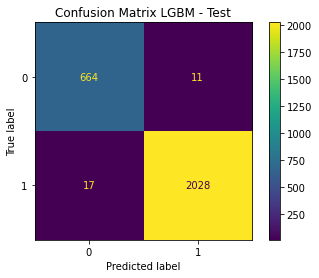

In [40]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix LGBM - Test')
plt.show()

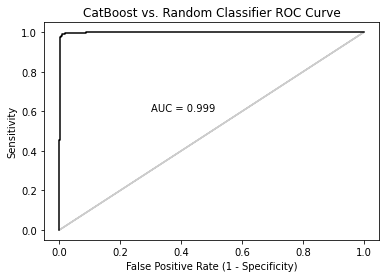

In [41]:
modelo_probabilidades = lgbm.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = metrics.roc_curve(y_test, modelo_probabilidades, pos_label=1)
auc = round(metrics.roc_auc_score(y_test, modelo_probabilidades),3)

plt.step(false_positive_rate_values, sensitivity_values, color='black', where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')

plt.step(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001), color='black', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('CatBoost vs. Random Classifier ROC Curve')
plt.annotate(f'AUC = {auc}', xy=(0.3, 0.6))

plt.show()

# Exportando o Modelo

In [39]:
pickle.dump(lgbm, open('../modelos/pipeline.pkl', 'wb'))